In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import torchvision
import gpytorch
import torch
from duste.DustAttnCalc import DustAttnCalc
import duste.DustAttnCalc as dd
import lbg_forecast.dust_priors as dp
import scipy as sc

import lbg_forecast.priors_gp_dust as gpdp

In [2]:
dust_prior = gpdp.DustPrior()
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.n, dust_prior.tau, dust_prior.tau1, dust_prior.ne, dust_prior.taue, dust_prior.tau1e, dust_prior.sfr
recent_sfrs, dust2, dust_index, dust1 = dust_prior.recent_sfrs, dust_prior.dust2, dust_prior.dust_index, dust_prior.dust1

Loading Models
Loading Complete


<ErrorbarContainer object of 3 artists>

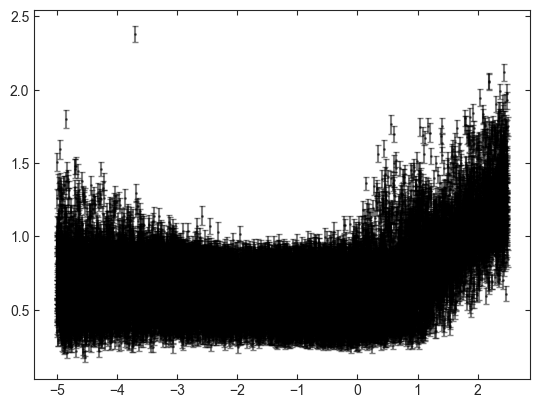

In [3]:
plt.errorbar(sfr, tau, taue, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(sfr, tau, -10, -5, 5)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

<ErrorbarContainer object of 3 artists>

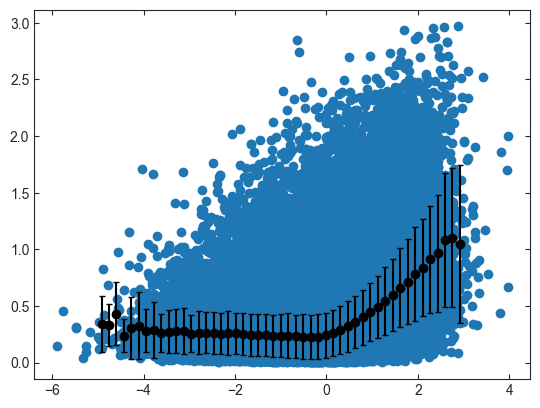

In [4]:
plt.scatter(recent_sfrs, dust2)
bin_centers, bin_means, bin_std = gpdp.process_samples(recent_sfrs, dust2, -5, 3, 50)
plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [5]:
train_sfrs, train_dust2, train_dust2_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
#avg_err = (bin_std + bin_std_de)/2
#x, y, yerr = gpdp.process_samples(train_sfrs, train_dust2, -4, 2.5, 25)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2, alpha=0.25)
#plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2, alpha=0.25)
#plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

1893.8351790787722
1849.0155286955646
1802.5560416383948
1754.5292327056864
1705.0219126127145
1654.1351392310617
1601.9838963430834
1548.696487568694
1494.4136442130075
1439.2873572947826
1383.4794552421392
1327.1599591483073
1270.5052564591872
1213.6961408260333
1156.9157700758071
1100.347595644744
1044.1733154962292
988.5708988111247
933.712725076468
879.7638732071059
826.880588625381
775.2089483161375
724.8837361651003
676.0275336919353
628.7500248907774
583.1475085503462
539.3026073009873
497.2841597029226
457.1472797592622
418.93356707223916
382.671450294527
348.37664649227077
316.0527195135396
285.6917213952993
257.274902116259
230.77347442247785
206.14942182652678
183.35633907598412
162.3402953489804
143.04071117337713
125.3912406270377
109.3206508163231
94.75369100481318
81.61194412481424
69.81465379152985
59.279520381679696
49.923460246621104
41.663322700717465
34.41656004348446
28.101846519895066
22.63964278228937
17.952703084041314
13.966523113369847
10.609727074479624
7.81

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


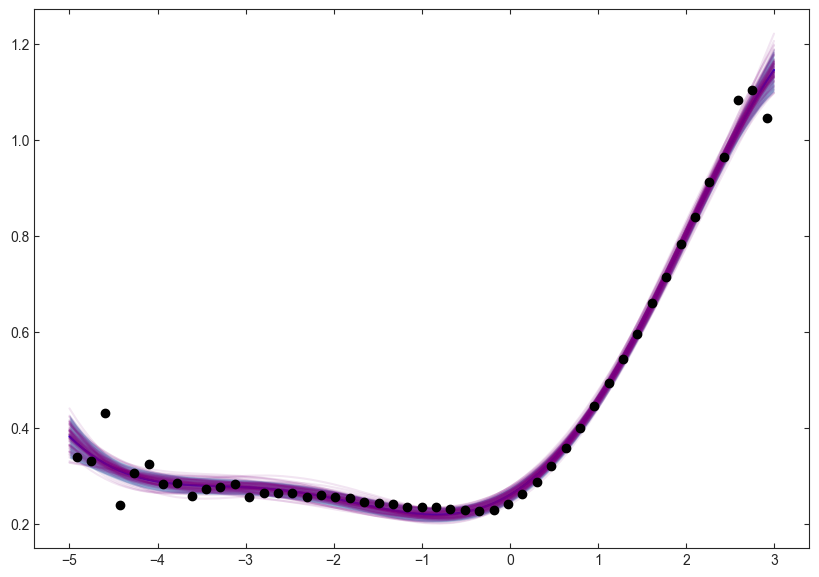

In [6]:
#train_sfrs, train_dust2, train_dust2_errs = torch.from_numpy(x), torch.from_numpy(y), torch.from_numpy(yerr)
test_sfrs = torch.linspace(-5, 3, 100)
trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_sfrs, train_dust2, [5.0, 15.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds_mu, test_sfrs, train_sfrs, train_dust2, train_dust2_errs*0, labelx="", labely="", alpha=0.5)

for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds_mu.sample().numpy(), c='purple', alpha=0.1)

1893.829470417473
1849.009503764003
1802.549652666389
1754.52242545027
1705.0146252850136
1654.1273010337
1601.9754256349918
1548.6872898138529
1494.4036098414676
1439.276359456629
1383.4673473868957
1327.1465725166454
1270.490397813401
1213.679590889577
1156.8972831208218
1100.3269005025086
1044.1501180749806
988.5448860955797
933.6835705959121
879.7312440370827
826.844154015488
775.1683899307077
724.8387597040967
675.9778814320514
628.69548855216
583.0879418581436
539.2379375844814
497.2143977759317
457.07252717914616
418.854019815812
382.5873980637506
348.28846731640715
315.96086994620407
285.59672321102585
257.1773267876163
230.67392669620256
206.0485234394071
183.25471318876785
162.23855180261128
142.9394323353872
125.29096747534334
109.22186899554723
94.65681680863774
81.51731059609143
69.72249729287573
59.18996802827435
49.83651853448359
41.57886758866363
34.334328753567874
28.02143147576656
22.560488402965607
17.874106502794376
13.887640141149259
10.52958469550596
7.73190958783

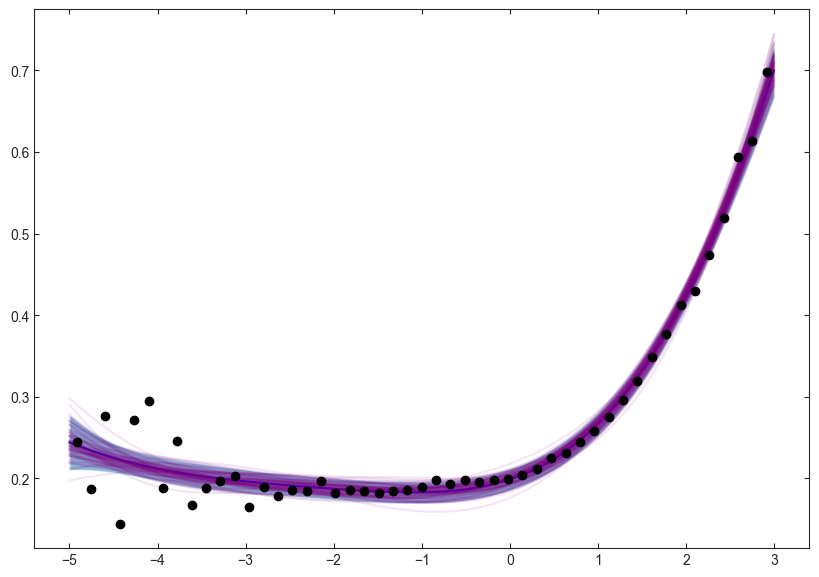

In [7]:
test_sfrs = torch.linspace(-5, 3, 100)
train_sfrs, train_dust2, train_dust2_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model_noerr(train_sfrs, train_dust2_errs, [5.0, 15.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds, test_sfrs, train_sfrs, train_dust2_errs, train_dust2_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds.sample().numpy(), c='purple', alpha=0.1)

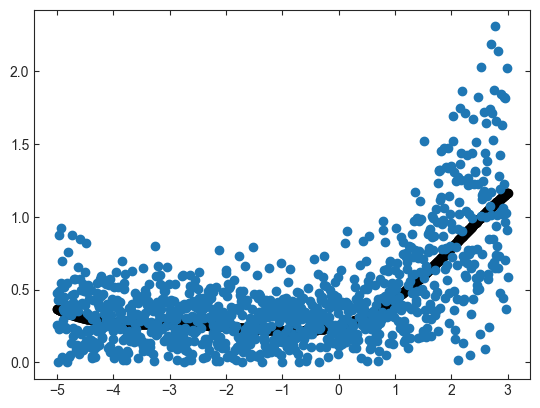

In [8]:
test_sfrs = torch.from_numpy(np.linspace(-5, 3, 1000))
#mean = np.interp(test_sfrs, train_sfrs, train_dust2)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
mean_dust2 = f_preds_mu.sample().numpy()
sig_dust2 = f_preds_sig.sample().numpy()
sig_dust2 = np.where(sig_dust2<0.001, 0.001, sig_dust2)
plt.scatter(test_sfrs, mean_dust2, c='k')
plt.scatter(test_sfrs, dp.truncated_normal(mean_dust2, sig_dust2, 0.0, 4.0, len(test_sfrs)))

In [9]:
torch.save(trained_model.state_dict(), 'gp_models/dust2.pth')
torch.save(trained_model_sig.state_dict(), 'gp_models/dust2sig.pth')

<ErrorbarContainer object of 3 artists>

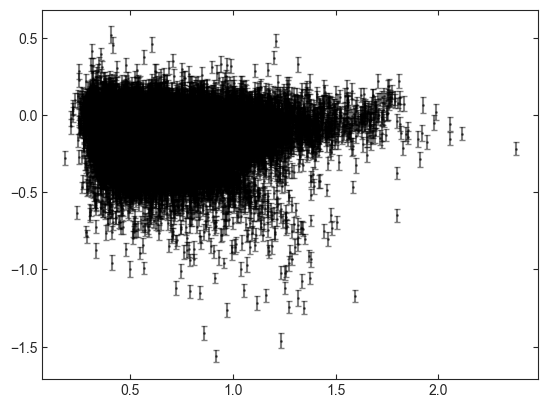

In [10]:
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, n, -10, -5, 2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(tau, n, ne, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

<ErrorbarContainer object of 3 artists>

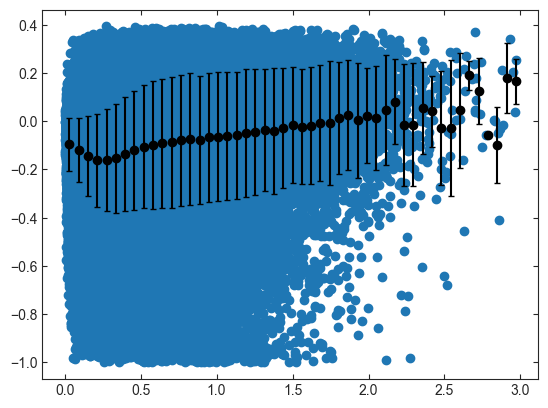

In [11]:
plt.scatter(dust2, dust_index)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust_index, 0.0, 3.0, 50)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [12]:
train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
#avg_err = (bin_std + bin_std_de)/2
#x, y, yerr = gpdp.process_samples(train_sfrs, train_dust_index, 0.0, 3.0, 50)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2, alpha=0.25)
#plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2, alpha=0.25)
#plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

175.27359279764667
161.83302812854808
148.3129584691558
134.8006107687141
121.39134440930252
108.18777227526151
95.2984949243624
82.8364059131756
70.91653286435422
59.653388575720534
49.1578206833318
39.53336984452865
30.87217902242528
23.25054495153815
16.724272008603457
11.324081464348222
7.0514431088543965
3.8753187912188416
1.7304100761734948
0.5175388730614845
0.10670342979720106
0.05821429243519215
0.009711335115894148
-0.03887380418091882
-0.08750519334944064
-0.13614380036090723
-0.1847477203646993
-0.2332722954453012
-0.281670148437995
-0.32989114826073823
-0.3778823215270668
-0.42558772344086715
-0.47294827991796334
-0.5199016123678055
-0.5663818564682103
-0.6123194864610291
-0.6576411568796445
-0.7022695740915561
-0.7461234105182238
-0.7891172748314683
-0.8311617518375413
-0.8721635262686723
-0.9120256055780152
-0.9506476585225427
-0.9879264894170836
-1.0237566730889416
-1.0580313831930779
-1.0906434565196774
-1.1214867470548717
-1.150457833219202
-1.1774581457398299
-1.2023

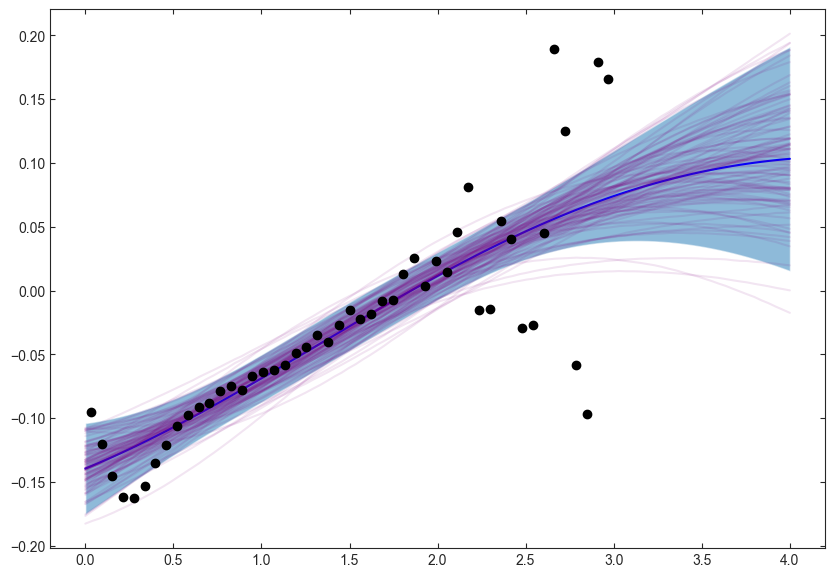

In [13]:
#train_dust2, train_dust_index, train_dust_index_errs = torch.from_numpy(bin_centers), torch.from_numpy(bin_means), torch.from_numpy(bin_std)

test_dust2 = torch.linspace(0, 4, 100)
#train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, x, y, yerr)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust_index, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

175.2733217510862
161.8327486336186
148.31266908265843
134.80030839080436
121.39102500586148
108.18743185144515
95.29813040672381
82.83601574183386
70.91611726987692
59.652949615716715
49.157362125246124
39.53289694355651
30.87169820259604
23.25006337901411
16.72379705232865
11.32362006137421
7.051001078502175
3.8749001645866237
1.7300165194823647
0.5171692811671388
0.10635374732109824
0.05789646011859629
0.009425653043501446
-0.039127558640178875
-0.08772751310141429
-0.13633552592976014
-0.18491017410623828
-0.23340747588990476
-0.2817809924814333
-0.3299818738542878
-0.3779588691472567
-0.42565832123877156
-0.47302416539404374
-0.5199979530365662
-0.5665189235754913
-0.6125241495792729
-0.6579487830378364
-0.7027264323611139
-0.7467897000814824
-0.7900709083371789
-0.8325030307128306
-0.874020831616776
-0.9145621840859901
-0.9540694898346421
-0.9924910596874295
-1.0297822321394465
-1.0659059272946054
-1.1008322828317194
-1.1345370426065675
-1.1669985138651275
-1.1981931972504392
-1.

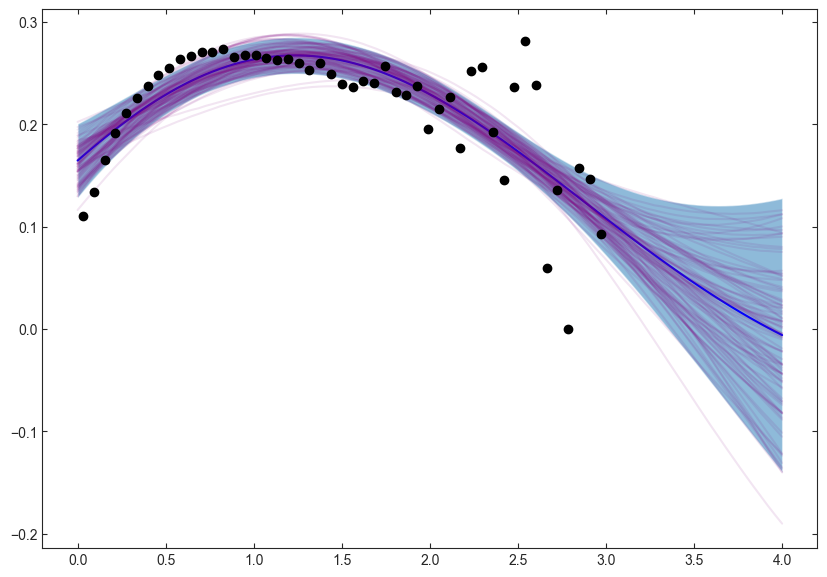

In [14]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model_noerr(train_dust2, train_dust_index_errs, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model_sig, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index_errs, train_dust_index_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

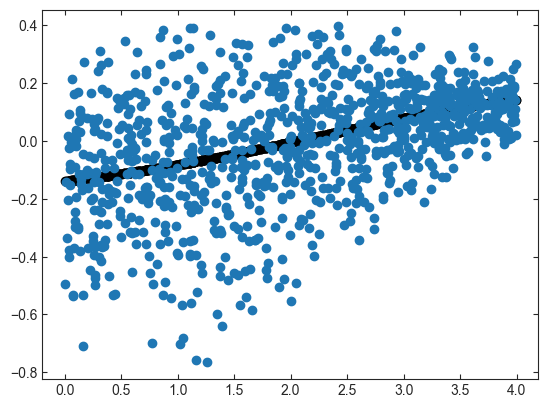

In [15]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_tau)
mean_dust_index = f_preds.sample().numpy()
sig_dust_index = f_preds_sig.sample().numpy()
sig_dust_index = np.where(sig_dust_index<0.001, 0.001, sig_dust_index)
#scatter = np.random.uniform(0.1, 0.4)
plt.scatter(test_tau, mean_dust_index, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust_index, sig_dust_index, -2.2, 0.4, len(test_tau)))

In [16]:
torch.save(trained_model.state_dict(), 'gp_models/dust_index.pth')
torch.save(trained_model_sig.state_dict(), 'gp_models/dust_indexsig.pth')

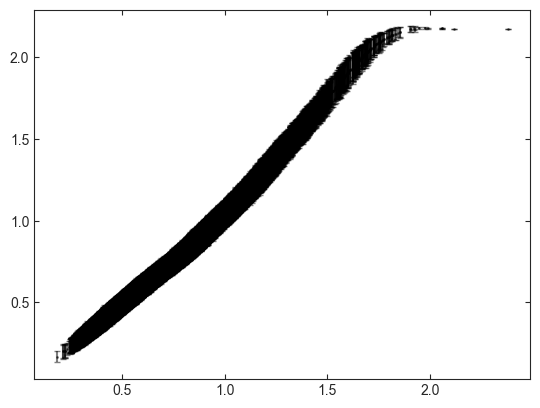

In [17]:
plt.errorbar(tau, tau1, tau1e, fmt='ko', ms=1, capsize=2, alpha=0.5)
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, tau1, -10, -5, 2)
x, y, yerr = gpdp.process_samples_modified(tau, tau1, tau1e, -10, -5, 2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

bin_centers_de, bin_means_de, bin_std_de = x, y, yerr


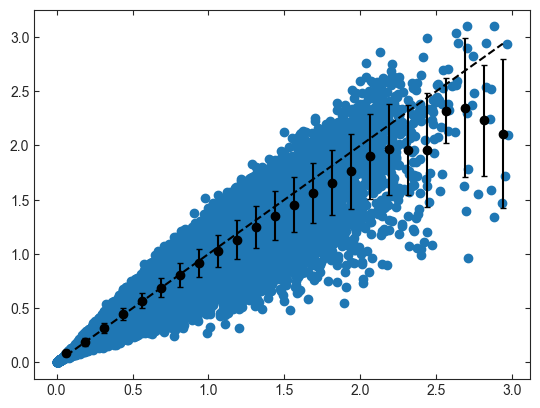

In [18]:
plt.scatter(dust2, dust1)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust1, 0.0, 3.0, 25)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')

357.10989783537553
329.71341680940617
302.15587255759976
274.61517414509586
247.285625753012
220.37655812688612
194.10970773656268
168.71560294905024
144.42912042062605
121.48407375910928
100.10678262795112
80.50863834267004
62.877752672120046
47.36987602881654
34.098912305610014
23.127546902704633
14.458737290446711
8.029065728360601
3.705163420366711
1.284490197470726
0.5015771494131409
0.4587817720847615
0.41623494982419057
0.37377934444863725
0.33146925295686996
0.2893624721416708
0.2475197855701042
0.2060048487338361
0.16488433960547827
0.1242282697626736
0.08411037479826512
0.0446085215928357
0.005805084052728153
-0.03221275177559437
-0.06935278736350516
-0.10551774915604827
-0.1406053988541701
-0.17450885588190146
-0.20711717715797953
-0.2383162454565552
-0.26799002299116775
-0.29602222989322047
-0.3222985061127778
-0.3467091076460942
-0.3691521711549466
-0.38953755194719925
-0.4077911959300111
-0.42385994418728984
-0.4377165886215711
-0.4493649010791451
-0.45884425374869564
-0.

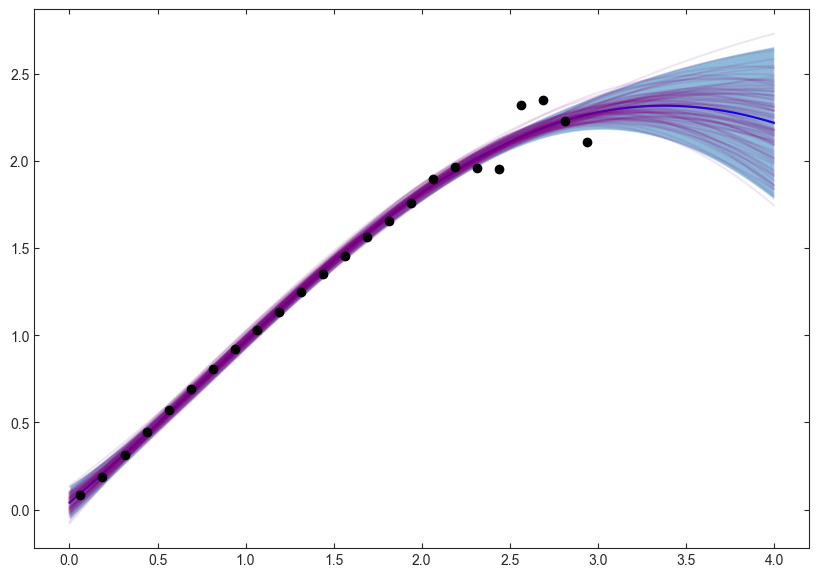

In [19]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust1, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

357.0306994706363
329.63022195534154
302.06809782541063
274.5224219539474
247.1878921976769
220.27401627313077
194.00252773866325
168.60392617837735
144.31306952018846
121.36376566285935
99.98233964544134
80.38019678943732
62.74546908702349
47.23393108637382
33.95951250934277
22.98492405997702
14.313145650030783
7.880776569685664
3.5544568850586375
1.1316442987153141
0.34685419488356684
0.3024352579520792
0.2585090942641201
0.21488993344652316
0.17159426919429413
0.1286317396535803
0.08600407047161657
0.04370533941374438
0.0017239031993235288
-0.03995387935879755
-0.08133836951538814
-0.12243051872021936
-0.1632159640819407
-0.2036605269203168
-0.243708026454689
-0.2832807635417829
-0.32228238798702846
-0.36060236401333134
-0.398121031669844
-0.43471434183531826
-0.47025763589959513
-0.5046282218892167
-0.5377068467512071
-0.5693783984725858
-0.5995322629448528
-0.628062728602191
-0.6548697262554082
-0.6798600665394118
-0.702949231849773
-0.7240637082561725
-0.7431437995700562
-0.76014

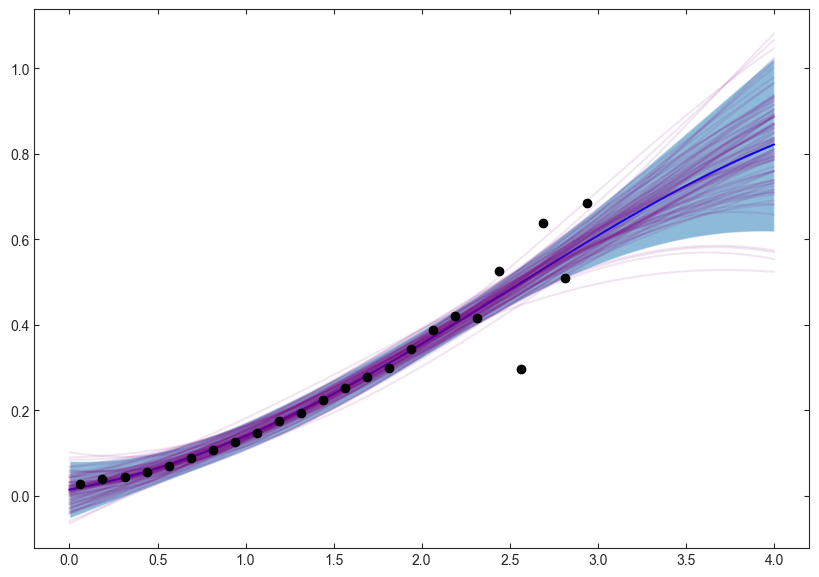

In [20]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model_noerr(train_dust2, train_dust1_errs, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model_sig, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1_errs, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

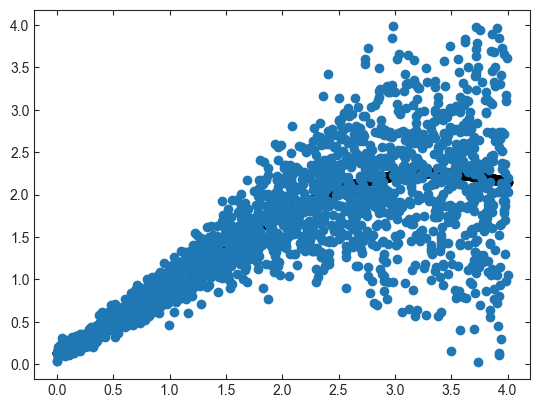

In [21]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 2000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_tau)
mean_dust1 = f_preds.sample().numpy()
sig_dust1 = f_preds_sig.sample().numpy()
sig_dust1 = np.where(sig_dust1<0.001, 0.001, sig_dust1)
#scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust1, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust1, sig_dust1, 0.0, 4.0, len(test_tau)))

In [22]:
torch.save(trained_model.state_dict(), 'gp_models/dust1.pth')
torch.save(trained_model_sig.state_dict(), 'gp_models/dust1sig.pth')